In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rand

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [3]:
import os
os.chdir('../../')

In [4]:
df_name = 'nov_nine_var.xlsx'

In [5]:
df = pd.read_excel('./documents/' + df_name).iloc[:,1::]
X = df.iloc[:,0:21].to_numpy()
y = df.iloc[:,-1].to_numpy()

In [6]:
goal_df = pd.read_excel('./documents/result/basic_formula.xlsx').iloc[:,-1].to_numpy()
goal = goal_df[[min(range(len(goal_df)), key=lambda i: goal_df[i])]]

In [7]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [8]:
ACTION_NUM = 5
LENGTH = 60

In [9]:
def make_dataset(X, length, n=150, test_size=0.2):
    X_data, y_data = [], []

    for i in range(int(n/(1-test_size))):
        idx = rand.randint(0, len(X)-length-2)
        X_data.append(X[idx:idx+length])
        y_data.append(X[idx+length+1])

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return train_test_split(X_data, y_data, test_size=test_size, shuffle=False)

In [10]:
class Model_(tf.keras.Model):
    def __init__(self):
        super(Model_, self).__init__()
        self.d0 = tf.keras.layers.LSTM(64, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotUniform() , return_sequences=True, dropout=0.2)
        self.d1 = tf.keras.layers.LSTM(32, activation='tanh', return_sequences=False)
        self.d2 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())
        self.d3 = tf.keras.layers.Dense(units=21, activation='linear')

        self.batch_norm = tf.keras.layers.BatchNormalization()

    def call(self, inputs):
        x = self.d0(inputs)
        x = self.d1(x)
        x = self.batch_norm(x, training=False)
        x = self.d2(x)
        x = self.d3(x)

        return x

In [12]:
power_lstm = Model_()
power_lstm.build(input_shape=(1, LENGTH, 21))
power_lstm.compile(optimizer='adam', loss='mse')

d = make_dataset(X, LENGTH, n=len(X))
power_lstm.fit(d[0], d[2], epochs=1000, batch_size=128, validation_data=(d[1], d[3]), verbose=1)

Epoch 1/1000
4/4 [==============================] - 4s 985ms/step - loss: 0.2698 - val_loss: 0.2188
Epoch 2/1000
4/4 [==============================] - 3s 852ms/step - loss: 0.2087 - val_loss: 0.1808
Epoch 3/1000
4/4 [==============================] - 3s 916ms/step - loss: 0.1738 - val_loss: 0.1438
Epoch 4/1000
4/4 [==============================] - 4s 940ms/step - loss: 0.1331 - val_loss: 0.1095
Epoch 5/1000
4/4 [==============================] - 3s 848ms/step - loss: 0.1026 - val_loss: 0.0853
Epoch 6/1000
4/4 [==============================] - 3s 897ms/step - loss: 0.0786 - val_loss: 0.0654
Epoch 7/1000
4/4 [==============================] - 4s 893ms/step - loss: 0.0629 - val_loss: 0.0539
Epoch 8/1000
4/4 [==============================] - 4s 945ms/step - loss: 0.0510 - val_loss: 0.0444
Epoch 9/1000
4/4 [==============================] - 4s 941ms/step - loss: 0.0424 - val_loss: 0.0383
Epoch 10/1000
4/4 [==============================] - 3s 886ms/step - loss: 0.0361 - val_loss: 0.0328

In [13]:
power_lstm.save('./model/power_lstm')

INFO:tensorflow:Assets written to: ./model/power_lstm\assets


INFO:tensorflow:Assets written to: ./model/power_lstm\assets


In [64]:
model_list = [Model_() for i in range(ACTION_NUM)]

In [66]:
for i in range(5):
    model_list[i].build(input_shape=(1, LENGTH, 21))
    model_list[i].compile(optimizer='adam', loss='mse')
    d = make_dataset(X, LENGTH)
    model_list[i].fit(d[0], d[2], epochs=1000, batch_size=128, validation_data=(d[1], d[3]), verbose=1)

Epoch 1/1000
2/2 [==============================] - 1s 658ms/step - loss: 0.1223 - val_loss: 0.1004
Epoch 2/1000
2/2 [==============================] - 1s 597ms/step - loss: 0.1019 - val_loss: 0.0875
Epoch 3/1000
2/2 [==============================] - 1s 615ms/step - loss: 0.0889 - val_loss: 0.0790
Epoch 4/1000
2/2 [==============================] - 1s 552ms/step - loss: 0.0801 - val_loss: 0.0734
Epoch 5/1000
2/2 [==============================] - 1s 547ms/step - loss: 0.0746 - val_loss: 0.0689
Epoch 6/1000
2/2 [==============================] - 1s 599ms/step - loss: 0.0700 - val_loss: 0.0646
Epoch 7/1000
2/2 [==============================] - 1s 546ms/step - loss: 0.0656 - val_loss: 0.0612
Epoch 8/1000
2/2 [==============================] - 1s 540ms/step - loss: 0.0619 - val_loss: 0.0583
Epoch 9/1000
2/2 [==============================] - 1s 556ms/step - loss: 0.0589 - val_loss: 0.0553
Epoch 10/1000
2/2 [==============================] - 1s 541ms/step - loss: 0.0559 - val_loss: 0.0518

In [15]:
dnn_model = tf.keras.models.load_model('./model/dnn.h5')

In [148]:
def shift_data(origin, d, length):
    shift_d = np.concatenate((origin[0][1::], d), axis=0).reshape(1, length, 21)
    return shift_d

In [13]:
class Node:
    def __init__(self, parent, state):
        self.parent = parent
        self.child = None
        self.state = state

In [157]:
class Tree:
    def __init__(self, leaf_num, grow_type):
        self.root = None
        self.state_list = []
        self.type = grow_type
        self.leaf_num = leaf_num
        self.size = 0
        self.depth = 1

    def _size(self):
        i = 0
        t = self.size
        while True:
            t -=  self.leaf_num**i
            i += 1

            if t == 0:
                break

        self.depth = i

    @tf.function
    def average_the_state(self, node, child_state):
        state = tf.Variable(tf.zeros((5, 1, 21)))
        for i in range(5):
            state = state[i].assign(child_state[i][0][-1].reshape(1, 21))

        mean_state = tf.reduce_mean(state, 0)
        return mean_state

    @tf.function
    def sort_by_value(self, node, child_state):
        value = tf.Variable(tf.zeros(5))
        for i in range(5):
            state = child_state[i][0][-1].reshape(1, 21)
            value = value[i].assign(dnn_model(state)[0][0])

        argsort_order = tf.argsort(value)
        return argsort_order

    def pruning(self, leaf_node):
        if leaf_node.parent == None:
            return
            
        if leaf_node.parent.parent == None:
            return

        node = leaf_node.parent.parent
        child_value_list = np.zeros((self.leaf_num, self.leaf_num))
        for i in range(self.leaf_num):
            if node.child[i] == None:
                break

            for ii in range(self.leaf_num):
                if node.child[i].child[ii] == None:
                    break

                child_value_list[i][ii] = dnn_model(node.child[i].child[ii].state[0][-1].reshape(1, 21))

            node.child[i].child = node.child[i].child[np.argmin(child_value_list[i])]

        return node

    def push(self, state):
        node = Node(None, state)

        node.child = [Node for i in range(self.leaf_num)]

        if type(self.type) == int:
            node.child[0] = Node(node, shift_data(state, model_list[self.type](state), LENGTH))
            self.size += 1

            return node

        child_state = np.zeros((5, 1, LENGTH, 21))

        for i in range(5):
            child_state[i] = shift_data(state, model_list[i](state), LENGTH)

        if self.type == 'min':
            sorting_child_state = self.sort_by_value(node, child_state)
            for j in range(self.leaf_num):
                i = sorting_child_state[j]
                node.child[j] = Node(node, child_state[i])

        if self.type == 'mean':
            mean_child_state = self.average_the_state(node, child_state)
            for i in range(self.leaf_num):
                node.child[i] = Node(node, shift_data(state, mean_child_state, LENGTH))
            
        self.size += 1

        return node
    
    def post_order(self):
        self.state_list = []
        def _post_order(node):
            if node.child != None:
                for i in range(self.leaf_num):
                    _post_order(node.child[i])
            self.state_list.append(node.state[0][-1].reshape(1, 21))

        _post_order(self.root)

    def sort_value_by_level(self):
        self.post_order()
        self._size()
        arr = np.zeros((self.depth, self.leaf_num))
        counter = np.zeros(self.depth, dtype=np.int8)

        c = self.depth -1
        for s in self.state_list:
            if counter[c] >= self.leaf_num:
                c -= 1

            arr[c][counter[c]] = dnn_model(s)
            counter[c] += 1

            if c == 0:
                break
            
            if counter[c] % self.leaf_num == 0 and self.leaf_num != 1:
                arr[c-1][counter[c-1]] = dnn_model(s)
                counter[c-1] += 1

        return arr

    def sort_state_by_level(self):
        self.post_order()
        self._size()
        arr = np.zeros((self.depth, self.leaf_num, 1, 21))
        counter = np.zeros(self.depth, dtype=np.int8)

        c = self.depth -1
        for s in self.state_list:
            if counter[c] >= self.leaf_num:
                c -= 1

            arr[c][counter[c]][0] = s
            counter[c] += 1

            if c == 0:
                break
            
            if counter[c] % self.leaf_num == 0 and self.leaf_num != 1:
                arr[c-1][counter[c-1]][0] = s
                counter[c-1] += 1

        return arr

In [158]:
def grow(leaf, grow_type, end, root_data):
    def _grow(tree, node, t, end):
        if t >= end:
            return

        if t % 2 == 0:
            tree.pruning(node)

        for i in range(leaf):
            node.child[i] = tree.push(node.child[i].state)
            _grow(tree, node.child[i], t+1, end)

    tree = Tree(leaf, grow_type)
    tree.root = tree.push(root_data)
    _grow(tree, tree.root, 0, end)

    return tree

In [159]:
b = []
for i in range(0, len(X)-LENGTH):
    b.append(X[i:i+LENGTH])
b = np.array(b).reshape(len(b), LENGTH, 21)

c_list = ['b', 'g', 'r', 'y', 'm']

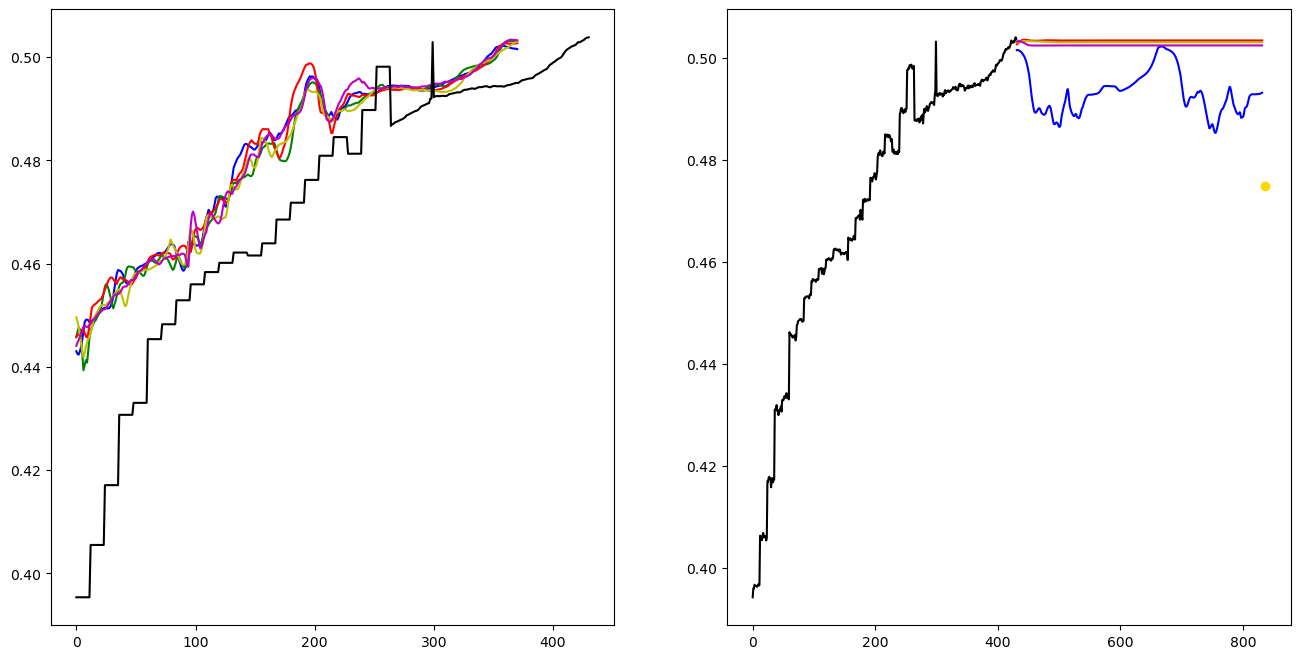

In [160]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)

for i in range(5):
    plt.plot(dnn_model.predict(model_list[i](b), verbose=0), c=c_list[i])

plt.plot(y, c='black')

plt.subplot(1, 2, 2)
real_data_len = len(X)
plt.plot([i for i in range(real_data_len)], dnn_model(X), c='black')

e = 400
root = b[-1].reshape(1, LENGTH, 21)

for t in range(ACTION_NUM):
    pred_list = []
    tree = grow(1, t, e, root)
    l = tree.sort_value_by_level()

    for j in range(l.shape[0]):
        for i in range(l.shape[1]):
            if l[j][i] != 0:
                pred_list.append(l[j][i])

    plt.plot([i for i in range(real_data_len, e+real_data_len+1)], pred_list, c=c_list[t])

plt.scatter(real_data_len+e+5, goal, c='gold')
plt.show()

In [162]:
for i in range(5):
    model_list[i].save('./model/action_net/action_net{0}'.format(i))
    print(i)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\keras\backend.py", line 4769, in <genexpr>
    output_ta_t = tuple(  File "c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\keras\backend.py", line 4769, in <genexpr>
    output_ta_t = tuple(  File "c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


INFO:tensorflow:Assets written to: ./model/action_net/action_net0\assets


INFO:tensorflow:Assets written to: ./model/action_net/action_net0\assets


0


INFO:tensorflow:Assets written to: ./model/action_net/action_net1\assets


INFO:tensorflow:Assets written to: ./model/action_net/action_net1\assets


1


INFO:tensorflow:Assets written to: ./model/action_net/action_net2\assets


INFO:tensorflow:Assets written to: ./model/action_net/action_net2\assets


2


INFO:tensorflow:Assets written to: ./model/action_net/action_net3\assets


INFO:tensorflow:Assets written to: ./model/action_net/action_net3\assets


3


INFO:tensorflow:Assets written to: ./model/action_net/action_net4\assets


INFO:tensorflow:Assets written to: ./model/action_net/action_net4\assets


4


In [83]:
faker = tf.keras.Sequential()
faker.add(tf.keras.layers.LSTM(128, input_shape=(12, 1), activation='tanh', return_sequences=False))
faker.add(tf.keras.layers.Dense(64, activation='relu'))
faker.add(tf.keras.layers.Dense(1, activation='linear'))
faker.compile(optimizer='adam', loss='mse')

In [103]:
X_data = []
y_data = []
for idx in range(len(y)-12-1):
    X_data.append(y[idx:idx+12])
    y_data.append(y[idx+12+1])
dd = train_test_split(np.array(X_data), np.array(y_data))
faker.fit(dd[0], dd[2], epochs=1000, batch_size=128, validation_data=(dd[1], dd[3]), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/1000
3/3 [==============================] - 0s 108ms/step - loss: 1.2716e-05 - val_loss: 2.0962e-05
Epoch 2/1000
3/3 [==============================] - 0s 140ms/step - loss: 1.3185e-05 - val_loss: 1.5099e-05
Epoch 3/1000
3/3 [==============================] - 0s 120ms/step - loss: 1.0499e-05 - val_loss: 1.3827e-05
Epoch 4/1000
3/3 [==============================] - 0s 123ms/step - loss: 9.4037e-06 - val_loss: 1.0338e-05
Epoch 5/1000
3/3 [==============================] - 0s 128ms/step - loss: 8.3433e-06 - val_loss: 9.0898e-06
Epoch 6/1000
3/3 [==============================] - 0s 117ms/step - loss: 7.6326e-06 - val_loss: 7.3468e-06
Epoch 7/1000
3/3 [==============================] - 0s 108ms/step - loss: 7.0956e-06 - val_loss: 7.2267e-06
Epoch 8/1000
3/3 [==============================] - 0s 103ms/step - loss: 6.8589e-06 - val_loss: 7.2206e-06
Epoch 9/1000
3/3 [==============================] - 0s 105ms/step - loss: 6.0427e-06 - val_loss: 7.4088e-06
Epoch 10/1000
3/3 [=========

In [134]:
def fake(data, li, t):
    if len(li) >= 100:
        return li
    
    d = faker(data).reshape(1, 1)
    v = np.concatenate((data[0][1::], d), axis=0).reshape(1, 12, 1)
    li.append(v)
    li = fake(li[-1], li, t+1)
    return li

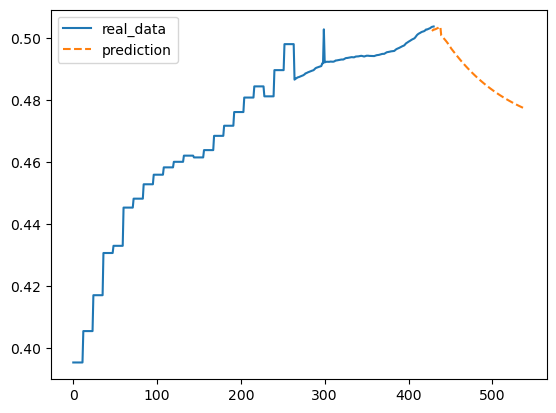

In [144]:
li = fake(y[-13:-1].reshape(1, 12, 1), [], 0)
a = []
for i in range(len(li)):
    a.append(li[i][0][0])
for i in range(11):
    a.append(li[99][0][i+1])
plt.plot(y, label='real_data')
plt.plot([i-3 for i in range(len(y), len(y)+len(a))], a, linestyle='dashed', label='prediction')
plt.legend()
plt.savefig('./documents/fig/faker_lstm.jpg')
plt.show()